In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from scipy.stats import uniform, randint
import time
import joblib

In [ ]:
warnings.filterwarnings('ignore')
train_data = pd.read_csv('/content/drive/MyDrive/Train AI 2/train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Train AI 2/test_data.csv')

In [ ]:
scaler = StandardScaler()
# Select numeric columns (for standardization)
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns

# Drop unwanted columns from the numeric columns
numeric_columns = numeric_columns.difference(['timestamp', 'col', 'row', 'aws-12', 'binary_label'])

# Fit and transform the training data
train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])

# Transform the test data using the same scaler (to avoid data leakage)
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# # Check the result
# print("Standardized train data:\n", train_data.head())
# print("Standardized test data:\n", test_data.head())

In [ ]:
X_train = train_data.drop(columns=['timestamp', 'col', 'row', 'aws', 'aws-12', 'binary_label'])
y_train = train_data['aws']
X_test = test_data.drop(columns=['timestamp', 'col', 'row', 'aws', 'aws-12', 'binary_label'])
y_test = test_data['aws']

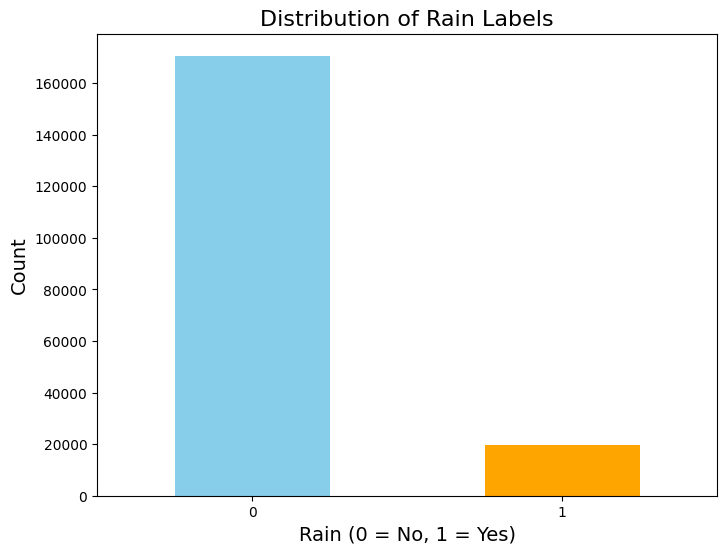

In [ ]:
# view data distribution
plt.figure(figsize=(8, 6))
train_data['binary_label'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Distribution of Rain Labels', fontsize=16)
plt.xlabel('Rain (0 = No, 1 = Yes)', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.show()
# plt.hist(train_data['aws'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
# plt.title('Original AWS Data Distribution')
# plt.xlabel('AWS (Rainfall)')
# plt.ylabel('Frequency')
# plt.show()

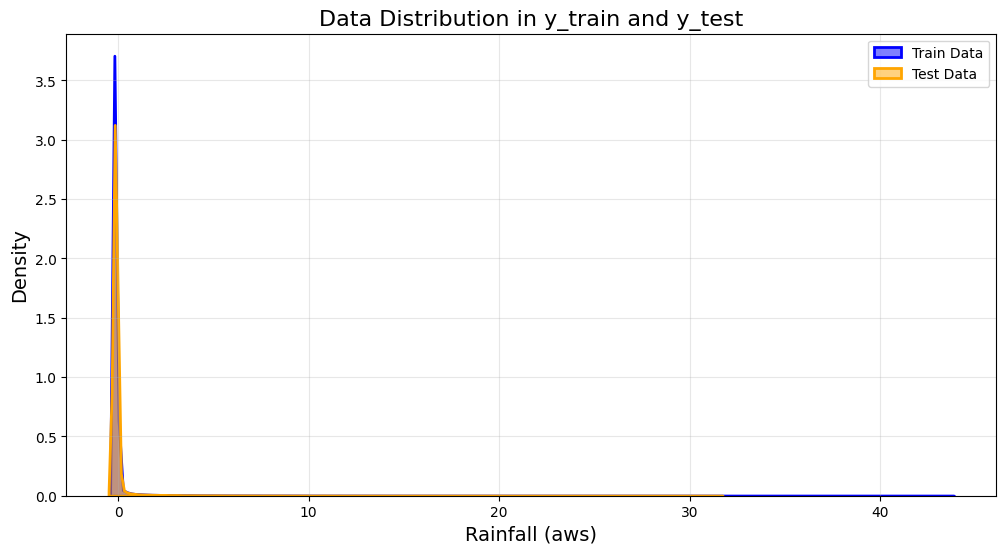

In [ ]:
# Plot Data Distribution
plt.figure(figsize=(12, 6))

# KDE plot for y_train
sns.kdeplot(y_train, fill=True, color='blue', alpha=0.5, label='Train Data', linewidth=2)

# KDE plot for y_test
sns.kdeplot(y_test, fill=True, color='orange', alpha=0.5, label='Test Data', linewidth=2)

# Labels and Title
plt.title('Data Distribution in y_train and y_test', fontsize=16)
plt.xlabel('Rainfall (aws)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
def objective(params):

    # Instantiate XGBRegressor with current parameters
    model = xgb.XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        min_child_weight=params['min_child_weight'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        random_state=42
    )

    # Perform cross-validation
    # many optimization algorithms, including cross_val_score, are designed to maximize scores rather than minimize errors
    score = -cross_val_score(model, X_train, y_train, cv=3, scoring='neg_mean_squared_error').mean()
    return {'loss': score, 'status': STATUS_OK}

    # model.fit(X_train_filtered, y_train, sample_weight=train_weights)

    # # Predict and evaluate on the validation set (you can use a holdout set or cross-validation)
    # y_pred = model.predict(X_test.drop(columns=['binary_label']))
    # mse = mean_squared_error(y_test, y_pred)

    # return mse

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50), # sample discrete values from 50 to 500 in increments of 50
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(1)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.0001), np.log(1))
}

trials = Trials()

# Run optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,  # Number of evaluations for Hyperopt to run
    trials=trials,
    rstate=np.random.default_rng(42)
)

# Print best parameters found
print("Best Parameters:", best)

100%|██████████| 50/50 [28:00<00:00, 33.60s/trial, best loss: 0.49906604352976097]
Best Parameters: {'colsample_bytree': 0.6099618735218424, 'gamma': 0.6208898919236316, 'learning_rate': 0.01061969793766288, 'max_depth': 15.0, 'min_child_weight': 5.0, 'n_estimators': 450.0, 'reg_alpha': 0.09900145638784154, 'reg_lambda': 0.0013720470192577002, 'subsample': 0.8415097158619497}


In [ ]:
# Define the parameter grid
param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],  # Discrete values
    'max_depth': range(3, 16),  # Discrete range from 3 to 15 (inclusive)
    'learning_rate': np.logspace(np.log10(0.01), np.log10(0.2), num=50),  # Logarithmic scale
    'subsample': np.linspace(0.6, 1.0, num=50),  # Uniform distribution between 0.6 and 1.0
    'colsample_bytree': np.linspace(0.6, 1.0, num=50),  # Uniform distribution between 0.6 and 1.0
    'min_child_weight': range(1, 11),  # Discrete range from 1 to 10 (inclusive)
    'gamma': np.linspace(0, 1, num=50),  # Uniform distribution between 0 and 1
    'reg_alpha': np.logspace(np.log10(0.0001), np.log10(1), num=50),  # Logarithmic scale
    'reg_lambda': np.logspace(np.log10(0.0001), np.log10(1), num=50),  # Logarithmic scale
}

model = xgb.XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter combinations to try
    scoring='neg_mean_squared_error',  # Use negative MSE for regression
    cv=3,  # 3-fold cross-validation
    random_state=42,
    verbose=1,
    n_jobs=-1  # Parallelize the search
)

random_search.fit(X_train, y_train)

# Retrieve the best model
best_model = random_search.best_estimator_

# Print the best parameters
print("Best Parameters:", random_search.best_params_)
# Print the best score (cross-validation score for the best model)
print("Best CV Score:", random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.7959183673469388, 'reg_lambda': 0.05963623316594643, 'reg_alpha': 0.00030888435964774815, 'n_estimators': 500, 'min_child_weight': 6, 'max_depth': 14, 'learning_rate': 0.023535468936502525, 'gamma': 0.2040816326530612, 'colsample_bytree': 0.6897959183673469}
Best CV Score: -0.5027925431195803


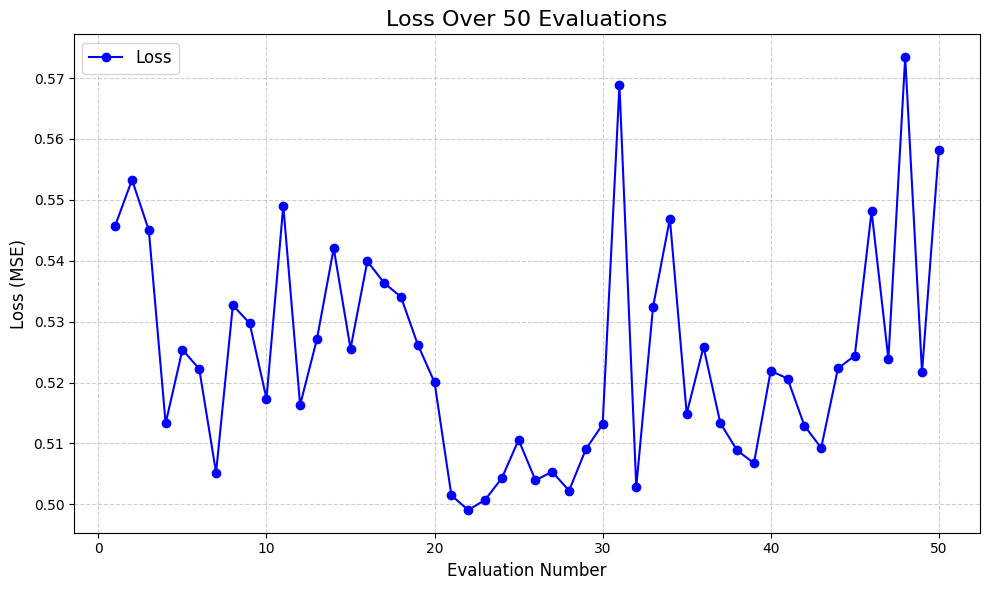

In [ ]:
#plot the loss over 50 eval
# Extract the loss values from the trials object
losses = [trial['result']['loss'] for trial in trials.trials]
eval_indices = range(1, len(losses) + 1)  # 1-based index for evaluations

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(eval_indices, losses, marker='o', linestyle='-', color='b', label='Loss')

# Add labels, title, and legend
plt.title('Loss Over 50 Evaluations', fontsize=16)
plt.xlabel('Evaluation Number', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

# Hyperopt may return some values in float even for integer parameters
best_model = xgb.XGBRegressor(
    n_estimators=best['n_estimators'],
    max_depth=best['max_depth'],
    learning_rate=best['learning_rate'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    min_child_weight=best['min_child_weight'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    random_state=42
)

In [ ]:
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6897959183673469, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.2040816326530612,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.023535468936502525,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=14, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 0.46362992916432105
Mean Absolute Error: 0.14104935324667472
R-squared: 0.532537817195013


In [ ]:
aws_index = numeric_columns.get_loc('aws')

target_mean = scaler.mean_[aws_index]
target_scale = scaler.scale_[aws_index]

# Destandardize y_test and y_pred
y_test_original = y_test * target_scale + target_mean
y_pred_original = y_pred * target_scale + target_mean

# Recalculate metrics on destandardized data
mse_original = mean_squared_error(y_test_original, y_pred_original)
mae_original = mean_absolute_error(y_test_original, y_pred_original)
r2_original = r2_score(y_test_original, y_pred_original)

# Print results
print("Metrics on Original Data Scale:")
print("Mean Squared Error:", mse_original)
print("Mean Absolute Error:", mae_original)
print("R-squared:", r2_original)

Metrics on Original Data Scale:
Mean Squared Error: 2.799628458421232
Mean Absolute Error: 0.34439476226452725
R-squared: 0.531286906034392


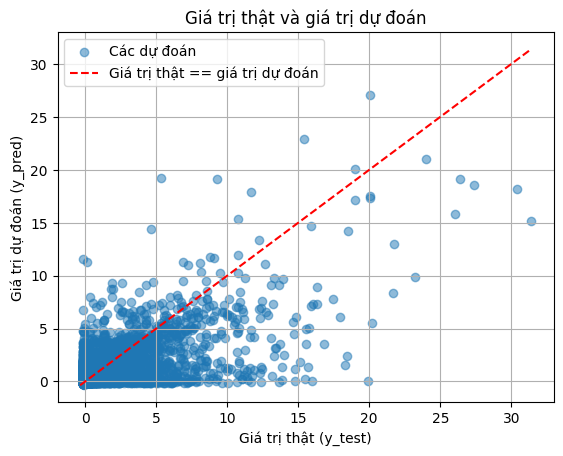

In [ ]:
#ploting model performance
# Scatter plot
plt.scatter(y_test, y_pred, alpha=0.5, label="Các dự đoán")

# Add diagonal line
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Giá trị thật == giá trị dự đoán")

# Add labels, grid, and legend
plt.title("Giá trị thật và giá trị dự đoán")
plt.xlabel("Giá trị thật (y_test)")
plt.ylabel("Giá trị dự đoán (y_pred)")
plt.grid()
plt.legend()
plt.show()

# plt.savefig('/content/drive/My Drive/Train AI 2/example_plot.png')
# plt.close()

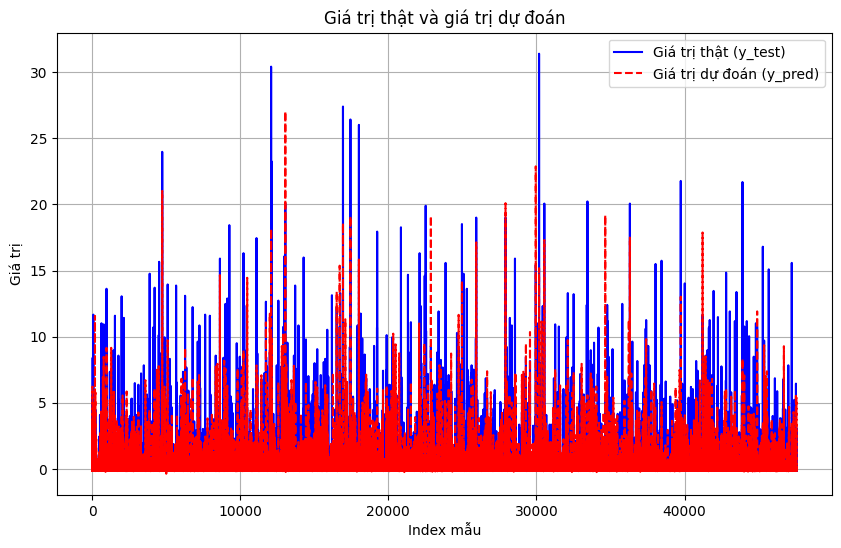

In [ ]:
# Generate an index for the samples
samples = np.arange(len(y_test))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the true values (y_test)
plt.plot(samples, y_test, color='blue', label='Giá trị thật (y_test)', linestyle='-')

# Plot the predicted values (y_pred)
plt.plot(samples, y_pred, color='red', label='Giá trị dự đoán (y_pred)', linestyle='--')

# Add labels, title, grid, and legend
plt.title('Giá trị thật và giá trị dự đoán')
plt.xlabel('Index mẫu')
plt.ylabel('Giá trị')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [ ]:
joblib.dump(best_model, '/content/drive/My Drive/Train AI 2/xgboost_model_2.joblib')
# best_model = joblib.load('/content/drive/My Drive/Train AI 2/xgboost_model.joblib') # if have trained a model

['/content/drive/My Drive/Train AI 2/xgboost_model_2.joblib']